
# Classifying gender of the Voxforge audio data with Convolutional Neural Networks and Recurrent Neural Networks
In this notebook, we will aproach the gender classification task of the audio data from Voxforge. In the first approach a convolutional neural network will be built for this binary classification problem. In the previous notebook we extracted the MFCC features from individual audio samples, and these features will be this used as our training data. The subsequent approach will utilize an LTSM RNN to classify the genders


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense,  Activation, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from keras.optimizers import Adam
from keras import optimizers
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint 

from keras.regularizers import l2
import os

## 1. Data preperation


### 1.1 Loading the MFCC data
In the previous notebook, we processed the data and save the features and their labels as numpy arrays. Our data containing X is a Numpy array of shape (4288, 13, 622) which represent the 4288 samples, with 13 MFCC coefficients and 622 frames as we zero padded the individual MFCCs to account for audio files of varying lengths. The y is 1D array consisting of values of either 1 or 0, 1 represent a Male label and 0 a Female label 

In [3]:
#This notebook was created using Google colab and thus
# X_balanced.npy and y_balanced.npy were generated from the previous notebook and uploaded to google drive

X = np.load("/content/drive/My Drive/gender_classification/X_balanced.npy")
y = np.load("/content/drive/My Drive/gender_classification/y_balanced.npy")

### 1.2 Split the data into training and testing

In [4]:
#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)

print("Test split: {} \t\t Train split: {}".format(len(X_train), len(X_train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 13154 		 Train split: 13154
X test shape: (5638, 13, 1023) 	 X train shape: (13154, 13, 1023)
y test shape: (5638,) 		 y train shape: (13154,)


### 1.3 Reshaping the data for the CNN
For the CNN we need to add an extra axis that represents the depth. For audio data the depth is usually 1. The first feature dimention  is the number of coefficients which is 13. The second dimension is that of the number of frames of the audio sample. This has been made consistent in the previous data collection preprocessing  notebook by padding samples with zeros ensuring that they are of the sample lenght of the longest sample. Finally, the depth or channels is set to 1.

In [5]:
feature_dim_1 = 13
feature_dim_2 = X[0].shape[1]
channels = 1
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channels)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channels)

# 2. Building a CNN model
A good starting point for building out the CNN are the architecutral principles of VGG models. The architecture involves stacking convolutional layers followed by a maxppoling layer. In subsequent layers the size of the filters is gradually increased. The final solution I have used which yielded optimal results, involved three of the aforementioned blocks, and the use of kernel regularization and dropout to prevent overfitting as well as batch normalization to speed up the training. 

**Model Architecture**
    
    -VGG Block 1 
    Convolution (32 filters, 3x3 size)
    Batch Normalization
    Convolution (32 filters, 3x3 size)
    Batch Normalization
    MaxPooling(2x2)
    Dropout(0.2)

    -VGG Block 2 
    Convolution (64 filters, 3x3 size)
    Batch Normalization
    Convolution (64 filters, 3x3 size)
    Batch Normalization
    MaxPooling(2x2)
    Dropout(0.3)

    -VGG Block 3
    Convolution (128 filters, 3x3 size)
    Batch Normalization
    Convolution (128 filters, 3x3 size)
    Batch Normalization
    MaxPooling(2x2)
    Dropout(0.4)

    -Fully connected and Sigmoid
    Dense 128
    Dropout (0.3)

    Dense 64
    Dropout (0.4)
    Dense 1 (sigmoid)



In [13]:
batch_size = 128
epochs = 50

def cnn_model():
    model = Sequential()
    #block 1
    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=l2(0.01), activation = 'relu', padding='same', input_shape=(feature_dim_1, feature_dim_2, channels)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    #block 2
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    #block 3 
    model.add(Conv2D(128, kernel_size=(3, 3), kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), kernel_regularizer=l2(0.01), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    #fully connected
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model


model = cnn_model()
model_file = 'cnn.hdf5'
model_path = os.path.join('/content', model_file)
optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
checkpoint = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
#binary cross-entropy as there are two classes
model.compile(loss=keras.losses.binary_crossentropy,optimizer=optimizer,metrics=['accuracy'])
#use part of the training set as validation
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks= [checkpoint], verbose=1, validation_split=1/10)

Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 4.2028 - accuracy: 0.5779
Epoch 00001: val_loss improved from inf to 4.09232, saving model to /content/cnn.hdf5
93/93 [==============================] - 16s 168ms/step - loss: 4.2028 - accuracy: 0.5779 - val_loss: 4.0923 - val_accuracy: 0.5198
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 3.9380 - accuracy: 0.7090
Epoch 00002: val_loss improved from 4.09232 to 3.91691, saving model to /content/cnn.hdf5
93/93 [==============================] - 16s 169ms/step - loss: 3.9380 - accuracy: 0.7090 - val_loss: 3.9169 - val_accuracy: 0.6793
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 3.7526 - accuracy: 0.7473
Epoch 00003: val_loss improved from 3.91691 to 3.74100, saving model to /content/cnn.hdf5
93/93 [==============================] - 16s 169ms/step - loss: 3.7526 - accuracy: 0.7473 - val_loss: 3.7410 - val_accuracy: 0.7082
Epoch 4/50
93/93 [==============================] - ETA:

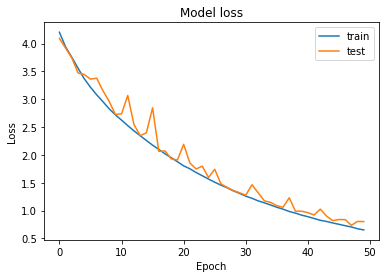

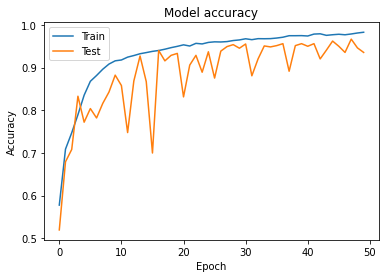

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
#making predictions on the unseen testing data using the cnn
cnn_model = load_model("/content/cnn.hdf5")
prediction = cnn_model.predict(X_test)
loss, metrics = cnn_model.evaluate(X_test, y_test)

177/177 [==============================] - 2s 12ms/step - loss: 0.7470 - accuracy: 0.9617


Using a CNN with an architecture similar to that of VGG, the CNN was able to produce an accuracy of 0.9617 on the unseen testing data. We can see that the accuracy of both training and testing/validation gradually increasing with the loss steadily decreasing. This acurracy could potentially be increased by augmenting the audio data using techniques of adding noise, shifting the phase, adjusting the picth etc. Overall, however, this is a relative good accuracy achieved on unseen testing data

# 3. Building a simple RNN-LTSM model
An RNN-LTSM model can be also used in this classification task. Here we set out to build a simple RNN that consists of 2 LTSM layers folowed by a dense layer. 

In [21]:
def rnn_model():
  
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64,return_sequences=True, input_shape=(feature_dim_1, feature_dim_2)))
    model.add(keras.layers.LSTM(64 ,return_sequences=True))
    model.add(keras.layers.LSTM(64))
    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    return model


In [28]:
#reload the data as it doesn't require reshaping for the RNN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)
epochs = 50

model  = rnn_model()


model_file = 'rnn.hdf5'
model_path = os.path.join('/content', model_file)

optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
checkpoint = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
#binary cross-entropy as there are two classes
model.compile(loss=keras.losses.binary_crossentropy,optimizer=optimizer,metrics=['accuracy'])
#use part of the training set as validation

model.compile(loss=keras.losses.binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks= [checkpoint], verbose=1, validation_split=1/10)

Epoch 1/50
88/93 [===========================>..] - ETA: 0s - loss: 0.6887 - accuracy: 0.5499
Epoch 00001: val_loss improved from inf to 0.68803, saving model to /content/rnn.hdf5
93/93 [==============================] - 2s 24ms/step - loss: 0.6886 - accuracy: 0.5509 - val_loss: 0.6880 - val_accuracy: 0.5722
Epoch 2/50
89/93 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5614
Epoch 00002: val_loss improved from 0.68803 to 0.68646, saving model to /content/rnn.hdf5
93/93 [==============================] - 1s 10ms/step - loss: 0.6872 - accuracy: 0.5618 - val_loss: 0.6865 - val_accuracy: 0.5904
Epoch 3/50
90/93 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5721
Epoch 00003: val_loss improved from 0.68646 to 0.68484, saving model to /content/rnn.hdf5
93/93 [==============================] - 1s 11ms/step - loss: 0.6858 - accuracy: 0.5715 - val_loss: 0.6848 - val_accuracy: 0.5995
Epoch 4/50
90/93 [============================>.] - ETA: 0s - 

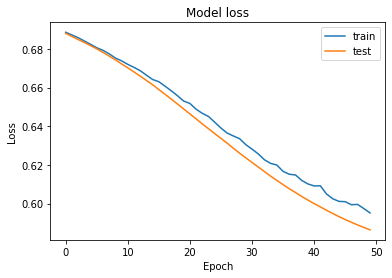

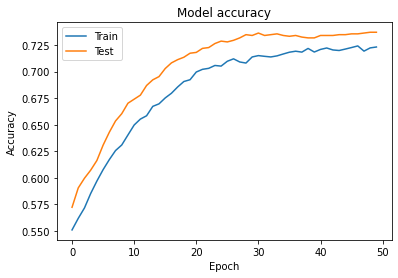

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
#making predictions on the unseen testing data using the rnn
rnn_model = load_model("/content/rnn.hdf5")
prediction = rnn_model.predict(X_test)
loss, metrics = rnn_model.evaluate(X_test, y_test)

177/177 [==============================] - 1s 4ms/step - loss: 0.5952 - accuracy: 0.7176


# Conclusion and choice of network
The RNN-LTMS's performance in comparison to the CNN above is drastically lower. The performance curves of loss and accuracy are also converging in this case which is a good sign. However, based on an accuracy of 0.9617 the CNN model built earlier is prefered over the RNN_LTSM model above. With that is the conclusion of the task. We have scraped the data from VOX forge, extracted important features such as the gender, age, dialect MFCC's. On that data exploration and visualization was carried out and finally the above two models were built, with the CNN performing exceptionally well. Going forward, the model accuracy could potentially be brought up by augmenting the data or adding more VGG blocks to the above CNN.